In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18

from qpfs import QPFS, MultivariateQPFS

In [2]:
def score_vs_alpha3(qpfs, mode, alpha3_array):
        
    alphas_history = []
    score_history = []
    for alpha3 in tqdm_notebook(alpha3_array):
        alphas = qpfs.get_alpha(mode, alpha3)
        qpfs.solve_problem(alphas, mode)
        alphas_history.append(alphas)
        score_history.append((qpfs.zx, qpfs.zy))
    return score_history, alphas_history

In [3]:
# проверим как работают алгоритмы
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
Y = np.repeat(y[:, np.newaxis], repeats=10, axis=1)
X = np.hstack([X, np.zeros((X.shape[0], 1))])

In [4]:
import numpy as np
import sklearn.feature_selection as sklfs
import scipy as sc
import cvxpy as cvx


def get_corr_matrix(X, Y=None, fill=0):
    if Y is None:
        Y = X
    if len(Y.shape) == 1:
        Y = Y[:, np.newaxis]
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    
    X_ = (X - X.mean(axis=0))
    Y_ = (Y - Y.mean(axis=0))
    
    idxs_nz_x = np.where(np.sum(X_ ** 2, axis = 0) != 0)[0]
    idxs_nz_y = np.where(np.sum(Y_ ** 2, axis = 0) != 0)[0]
    
    X_ = X_[:, idxs_nz_x]
    Y_ = Y_[:, idxs_nz_y]
    
    corr = np.ones((X.shape[1], Y.shape[1])) * fill
    
    for i, x in enumerate(X_.T):
        corr[idxs_nz_x[i], idxs_nz_y] = Y_.T.dot(x) / np.sqrt(np.sum(x ** 2) * np.sum(Y_ ** 2, axis=0, keepdims=True))
    return corr


def shift_spectrum(Q, eps=0.):
    lamb_min = sc.linalg.eigh(Q)[0][0]
    if lamb_min < 0:
        Q = Q - (lamb_min - eps) * np.eye(*Q.shape)
    return Q, lamb_min


class QPFS:
    def __init__(self, sim='corr'):
        if sim not in ['corr', 'info']:
            raise ValueError('Similarity measure should be "corr" or "info"')
        self.sim = sim
    
    def get_params(self, X, y):
        self.m, self.n = X.shape
        self.r = y.shape[1] if len(y.shape) > 1 else 1
        if self.sim == 'corr':
            self.Q = np.abs(get_corr_matrix(X, fill=1))
            self.b = np.sum(np.abs(get_corr_matrix(X, y)), axis=1)[:, np.newaxis]
        elif self.sim == 'info':
            self.Q = np.ones([X.shape[1], X.shape[1]])
            self.b = np.zeros((X.shape[1], 1))
            for j in range(n_features):
                self.Q[:, j] = sklfs.mutual_info_regression(X, X[:, j])
            if len(y.shape) == 1:
                self.b = sklfs.mutual_info_regression(X, y)[:, np.newaxis]
            else:
                for y_ in y:
                    self.b += sklfs.mutual_info_regression(X, y_)
        self.Q, self.lamb_min = shift_spectrum(self.Q)
    
    def get_alpha(self):
        return self.Q.mean() / (self.Q.mean() + self.b.mean())

    def fit(self, X, y):
        self.get_params(X, y)
        alpha = self.get_alpha()
        self.solve_problem(alpha)
    
    def solve_problem(self, alpha):
        z = cvx.Variable(self.n)
        c = np.ones((self.n, 1))
        objective = cvx.Minimize((1 - alpha) * cvx.quad_form(z, self.Q) - 
                                 alpha * self.b.T * z)
        constraints = [z >= 0, c.T * z == 1]
        prob = cvx.Problem(objective, constraints)

        prob.solve()

        self.status = prob.status
        self.zx = np.array(z.value).flatten()
        self.zy = 1. / self.r * np.ones(self.r)
        
    def get_topk_indices(self, k=10):
        return self.score.argsort()[::-1][:k]


class MultivariateQPFS():
    def __init__(self):
        pass
    
    def get_params(self, X, Y):
        self.m, self.n = X.shape
        self.r = Y.shape[1] if len(Y.shape) > 1 else 1
        
        self.Qx = np.abs(get_corr_matrix(X, fill=1))
        self.Qy = np.abs(get_corr_matrix(Y, fill=1))
        self.B = np.abs(get_corr_matrix(X, Y))
        self.b = self.B.max(axis=0, keepdims=True)

    def get_alpha(self, mode, alpha3=None):
        if mode in ['SymImp', 'MaxMin', 'MinMax', 'MaxRel', 'MinMax2']:
            den = (np.mean(self.Qx) * np.mean(self.B)
                   + np.mean(self.Qx) * np.mean(self.Qy)
                   + np.mean(self.Qy) * np.mean(self.B))
            if alpha3 is None:
                alpha3 = np.mean(self.Qx) * np.mean(self.B) / den

            alpha1 = (1 - alpha3) * np.mean(self.B) / (np.mean(self.Qx) + np.mean(self.B))
            alpha2 = (1 - alpha3) * np.mean(self.Qx) / (np.mean(self.Qx) + np.mean(self.B))
        elif mode == 'AsymImp':
            den = (np.mean(self.Qx) * (np.mean(self.b) - np.mean(self.B))
                   + np.mean(self.Qx) * np.mean(self.Qy)
                   + np.mean(self.Qy) * np.mean(self.B))
            if alpha3 is None:
                alpha3 = np.mean(self.Qx) * (np.mean(self.b) - np.mean(self.B)) / den

            alpha1 = (1 - alpha3) * np.mean(self.B) / (np.mean(self.Qx) + np.mean(self.B))
            alpha2 = (1 - alpha3) * np.mean(self.Qx) / (np.mean(self.Qx) + np.mean(self.B))
        else:
            raise ValueError(f'Unknown mode: {mode}')
        return np.array([alpha1, alpha2, alpha3])


    def fit(self, X, Y, mode='SymImp'):
        self.get_params(X, Y)
        alphas = self.get_alpha(mode)
        self.solve_problem(alphas, mode)
    
    def solve_problem(self, alphas, mode='SymImp'):
        if mode == 'SymImp':
            self._symimp(alphas)
        elif mode == 'MaxMin':
            self._maxmin(alphas)
        elif mode == 'MinMax':
            self._minmax(alphas)
        elif mode == 'MaxRel':
            self._maxrel(alphas)
        elif mode == 'MinMax2':
            self._minmax2(alphas)
        elif mode == 'AsymImp':
            self._asymimp(alphas)
        else:
            raise ValueError('Unknown mode')
    
    def _symimp(self, alphas):
        # Parameters
        Q = np.vstack((np.hstack((alphas[0] * self.Qx, -alphas[1] / 2 * self.B)),
                       np.hstack(( -alphas[1] / 2 * self.B.T, alphas[2] * self.Qy))))
        Q, lamb_min = shift_spectrum(Q)
        
        c = np.zeros((2, self.n + self.r))
        c[0, :self.n] = 1
        c[1, self.n:] = 1
        
        # Problem
        z = cvx.Variable(self.n + self.r)
        obj = cvx.Minimize(cvx.quad_form(z, Q))
        constr = [z >= 0, c * z == 1]
        prob = cvx.Problem(obj, constr)
        prob.solve()

        # Results
        score = np.array(z.value).flatten()
        self.status = prob.status
        self.zx = score[:self.n]
        self.zy = score[-self.r:]
    
    def _asymimp(self, alphas):
        # Parameters
        Q = np.vstack((np.hstack((alphas[0] * self.Qx, -alphas[1] / 2 * self.B)),
                       np.hstack((-alphas[1] / 2 * self.B.T, alphas[2] * self.Qy))))
        Q, lamb_min = shift_spectrum(Q)
        
        c = np.zeros((2, self.n + self.r))
        c[0, :self.n] = 1
        c[1, self.n:] = 1
        
        # Problem
        z = cvx.Variable(self.n + self.r)
        obj = cvx.Minimize(cvx.quad_form(z, Q) + alphas[1] * self.b * z[self.n:])
        constr = [z >= 0, c * z == 1]
        prob = cvx.Problem(obj, constr)
        prob.solve()

        # Results
        score = np.array(z.value).flatten()
        self.status = prob.status
        self.zx = score[:self.n]
        self.zy = score[-self.r:]
        
    def _minmax2(self, alphas):
        # Parameters
        c = np.ones(self.r)
        
        Q, lamb_min = shift_spectrum(self.Qy, eps=1e-9)
        
        # Problem
        zy = cvx.Variable(self.r)
        obj = cvx.Minimize(alphas[2] * cvx.quad_form(zy, Q) + 
                           alphas[1] * self.B.mean(axis=0) * zy)
        constr = [zy >= 0, c * zy == 1]
        prob = cvx.Problem(obj, constr)
        prob.solve(solver=cvx.CVXOPT)
        
        # Results
        self.zy = np.array(zy.value).flatten()
        #-------------------------------------
        # Parameters
        c = np.ones(self.n)
        
        Q, lamb_min = shift_spectrum(self.Qx, eps=1e-9)
        
        # Problem
        zx = cvx.Variable(self.n)
        obj = cvx.Minimize(alphas[0] * cvx.quad_form(zx, Q) - 
                           alphas[1] * self.B.dot(self.zy).flatten() * zx)
        constr = [zx >= 0, c * zx == 1]
        prob = cvx.Problem(obj, constr)
        prob.solve(solver=cvx.CVXOPT)
        
        # Results
        self.status = prob.status
        self.zx = np.array(zx.value).flatten()
        self.zy = np.array(zy.value).flatten()
    
    def get_topk_indices(self, k=10):
        return self.zx.argsort()[::-1][:k]

In [5]:
qpfs = QPFS()
mqpfs = MultivariateQPFS()

qpfs.fit(X, y)
print('\t'.join(['{:.4f}'.format(x) for x in qpfs.zx]))
print('\t'.join(['{:.4f}'.format(x) for x in qpfs.zy]))

qpfs.fit(X, Y)
print('\t'.join(['{:.4f}'.format(x) for x in qpfs.zx]))
print('\t'.join(['{:.4f}'.format(x) for x in qpfs.zy]))

mqpfs.fit(X, y, mode='MinMax2')
print('\t'.join(['{:.4f}'.format(x) for x in mqpfs.zx]))
print('\t'.join(['{:.4f}'.format(x) for x in mqpfs.zy]))

mqpfs.fit(X, Y, mode='MinMax2')
print('\t'.join(['{:.4f}'.format(x) for x in mqpfs.zx]))
print('\t'.join(['{:.4f}'.format(x) for x in mqpfs.zy]))

0.0722	0.0607	0.0455	0.1049	0.0425	0.1967	0.0371	0.0000	0.0247	0.0492	0.1248	0.0866	0.1551	0.0000
1.0000
0.0721	0.0607	0.0455	0.1049	0.0425	0.1967	0.0371	0.0000	0.0247	0.0492	0.1248	0.0866	0.1551	0.0000
0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000
0.0753	0.0661	0.0438	0.1167	0.0430	0.1857	0.0415	0.0000	0.0288	0.0474	0.1213	0.0918	0.1386	-0.0000
1.0000
0.0753	0.0661	0.0438	0.1167	0.0430	0.1857	0.0415	0.0000	0.0288	0.0474	0.1213	0.0918	0.1386	-0.0000
0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000


In [6]:
# пример, где qpfs плох, а mqpfs гуд

Q = np.array([[1., 0., .0],
               [0., 1., 0.8],
               [.0, 0.8, 1.]])
Qx = Q.copy()
print(Q)
r = 5
Qy = np.ones((r, r)) * 0.2
Qy[:r - 1, :r - 1] = np.ones((r - 1, r - 1))
np.fill_diagonal(Qy, 1.)
print(Qy)
B = np.hstack((np.repeat(np.array([[0.4], [0.5], [0.8]]), repeats=r - 1, axis=1), 
               np.array([[0.], [.8], [.1]])))
print(B[:, :17])
b = np.mean(B, axis=1, keepdims=True)
print(b)

[[ 1.   0.   0. ]
 [ 0.   1.   0.8]
 [ 0.   0.8  1. ]]
[[ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 1.   1.   1.   1.   0.2]
 [ 0.2  0.2  0.2  0.2  1. ]]
[[ 0.4  0.4  0.4  0.4  0. ]
 [ 0.5  0.5  0.5  0.5  0.8]
 [ 0.8  0.8  0.8  0.8  0.1]]
[[ 0.32]
 [ 0.56]
 [ 0.66]]


In [7]:
mode = 'SymImp'

mqpfs.Qx = Qx
mqpfs.Qy = Qy
mqpfs.B = B
mqpfs.n, mqpfs.r = B.shape
mqpfs.b = mqpfs.B.max(axis=0, keepdims=True)

alphas = mqpfs.get_alpha(mode)
print(alphas)
mqpfs.solve_problem(alphas, mode)

print('\t'.join(['{:.4f}'.format(x) for x in mqpfs.zx]))
print('\t'.join(['{:.4f}'.format(x) for x in mqpfs.zy]))

[ 0.37276597  0.37115227  0.25608176]
0.3835	0.5213	0.0952
0.1322	0.1322	0.1322	0.1322	0.4712


In [8]:
alpha3_array = np.linspace(0, 1, 300)
score_history, alphas_history = score_vs_alpha3(mqpfs, mode, alpha3_array)

A Jupyter Widget

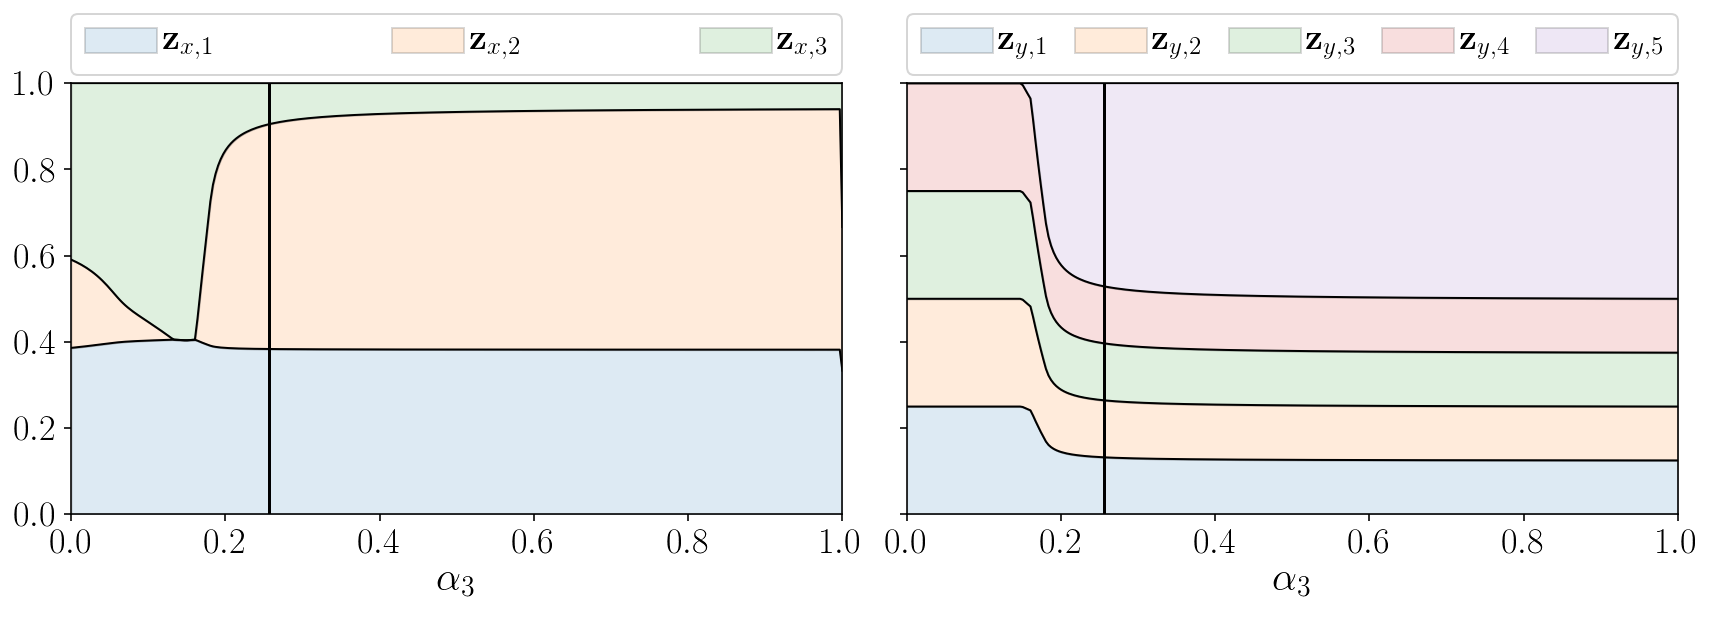

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
n_x, n_y = mqpfs.B.shape
prev = 0.
for i in range(n_x):
    cur = [np.sum(sh[0][:i + 1]) for sh in score_history]
    ax1.plot(alpha3_array, cur, c='k', linewidth=1.)
    ax1.fill_between(alpha3_array, cur, prev, edgecolor='k', alpha=.15, 
                     label=r'{}'.format('$\mathbf{z}_{x,' + str(i + 1) + '}$'))
    prev = cur

ax1.axvline(x=alphas[-1], c='k')
ax1.set_ylim(0., 1.)
ax1.set_xlim(0., 1.)

ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=n_x, mode="expand", borderaxespad=0., frameon=True, handletextpad=0.15)
ax1.set_xlabel(r'$\alpha_3$')

prev = 0.
for i in range(n_y):
    cur = [np.sum(sh[1][:i + 1]) for sh in score_history]
    ax2.plot(alpha3_array, cur, c='k', linewidth=1.)
    ax2.fill_between(alpha3_array, cur, prev, alpha=0.15, edgecolor='k', 
                     label=r'{}'.format('$\mathbf{z}_{y,' + str(i + 1) + '}$'))
    prev = cur

ax2.axvline(x=alphas[-1], c='k')
ax2.set_ylim(0., 1.)
ax2.set_xlim(0., 1.)

lgd = ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=n_y, mode="expand", borderaxespad=0., frameon=True, handletextpad=0.15)
ax2.set_xlabel(r'$\alpha_3$')

fig.tight_layout()
fig.subplots_adjust()
fig.savefig('figs/features_vs_alpha.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()